# How to Use XGBoost for Time-Series Forecasting?

Source: 
Nitika Sharma, How to Use XGBoost for Time-Series Forecasting?
https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/

Raghav Agrawal, Time series Forecasting: Complete Tutorial | Part-1
https://www.analyticsvidhya.com/blog/2021/07/time-series-forecasting-complete-tutorial-part-1/


## Traditional Methods for Forecasting

In [7]:
# Step 1: Load the data: 
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

df = pd.read_csv("data/Electric_Production.csv", header=0, index_col=0)
df.rename(columns={'IPG2211A2N': 'Value'}, inplace=True)
print(df.shape)
df.head()

(397, 1)


,Value
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151


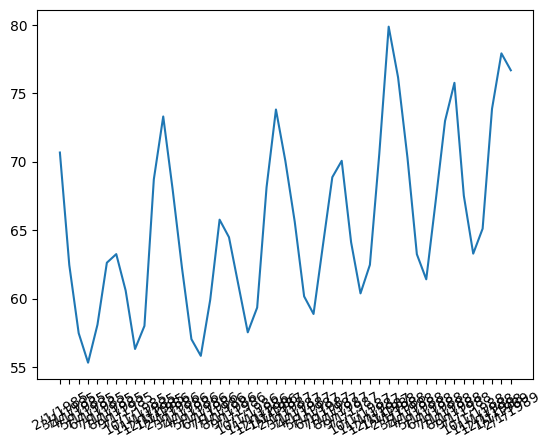

<Figure size 2000x1000 with 0 Axes>

In [8]:
plt.plot(df[1:50]["Value"])
plt.xticks(rotation=30)
plt.figure(figsize = (20, 10))
plt.show()

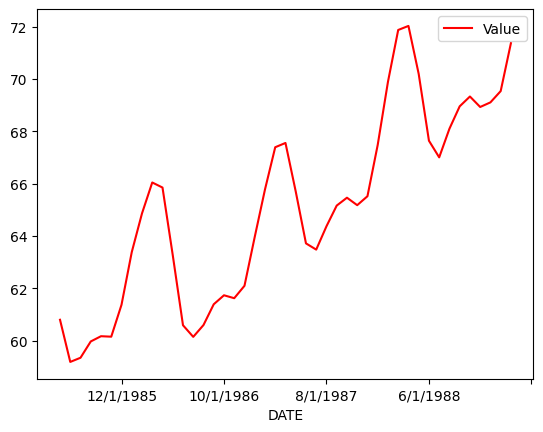

In [9]:
# Step 2: Moving Average method
rollingseries = df[1:50].rolling(window=5)
rollingmean = rollingseries.mean() #we can compute any statistical measure
#print(rollingmean.head(10))
rollingmean.plot(color="red")
plt.show()

/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


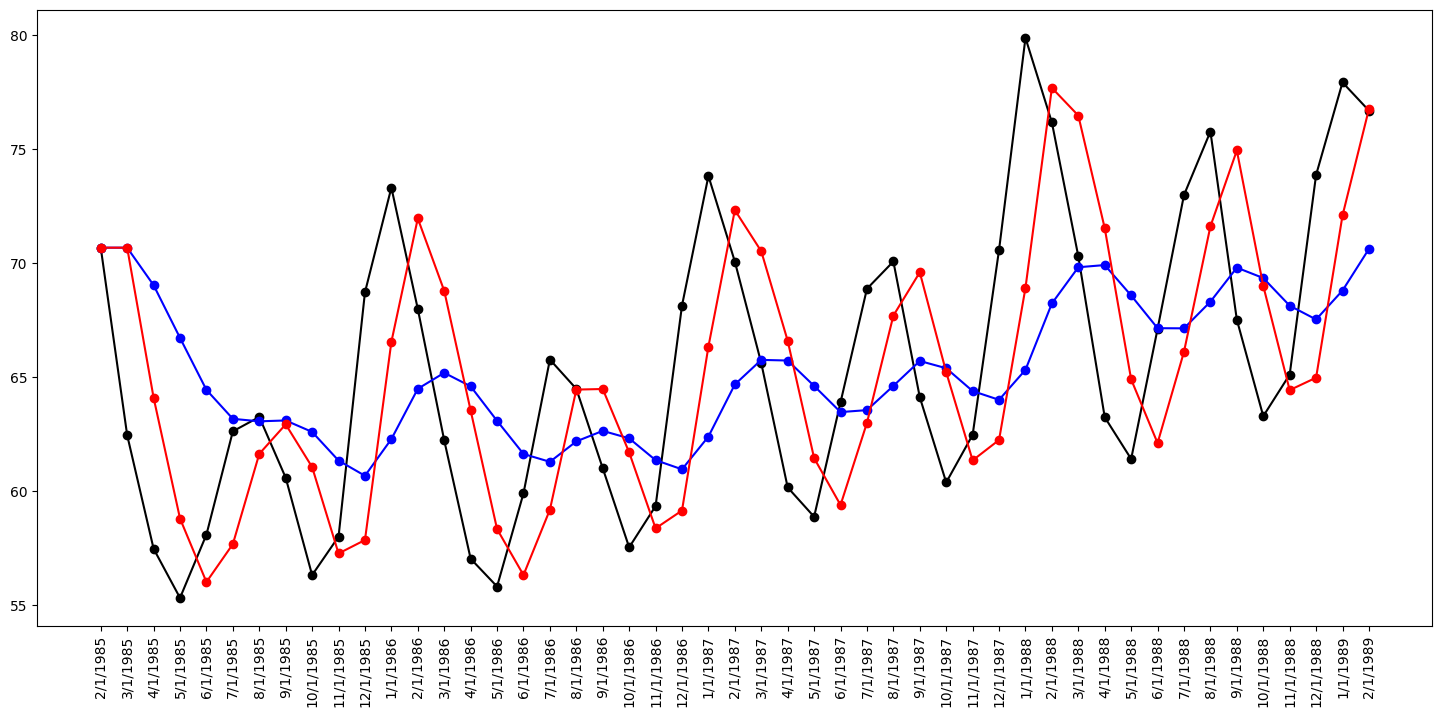

In [10]:
# Step 3: Simple Exponential Smoothing
data = df[1:50]
fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2, optimized=False)
fit2 = SimpleExpSmoothing(data).fit(smoothing_level=0.8, optimized=False)
plt.figure(figsize=(18, 8))
plt.plot(df[1:50], marker='o', color="black")
plt.plot(fit1.fittedvalues, marker="o", color="b")
plt.plot(fit2.fittedvalues, marker="o", color="r")
plt.xticks(rotation="vertical")
plt.show()

/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


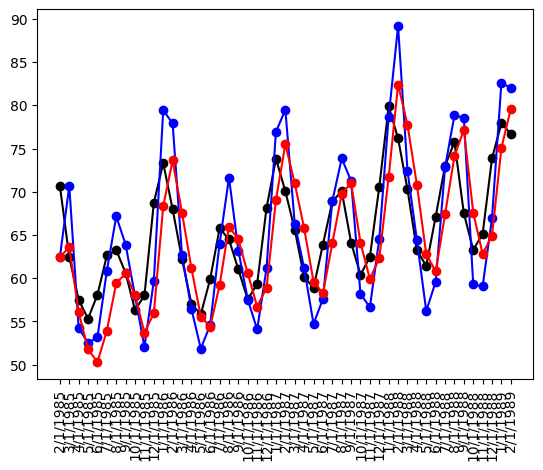

In [11]:
# Step 4: Holt method for exponential smoothing
fit1 = Holt(data).fit()  #linear trend
fit2 = Holt(data, exponential=True).fit()  #exponential trend
plt.plot(data, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='b')
plt.plot(fit2.fittedvalues, marker='o', color='r')
plt.xticks(rotation="vertical")
plt.show()

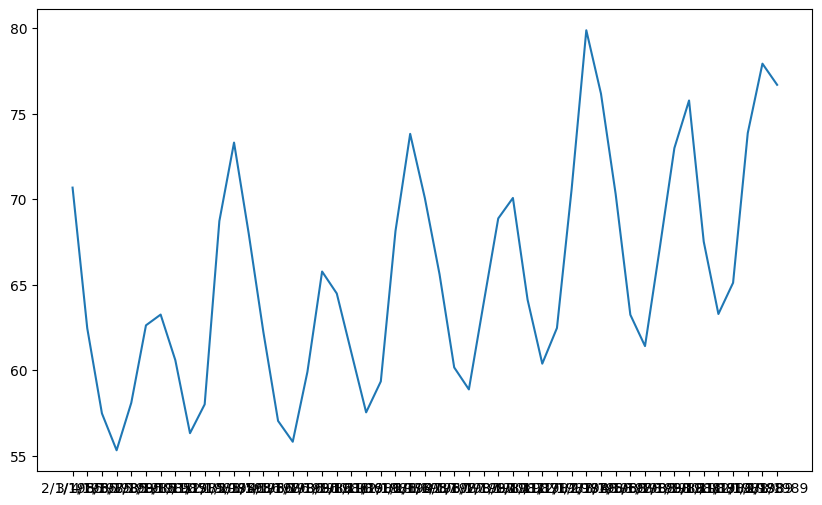

In [13]:
# Decomposition and stationarity check practicals

# Step 1: Load dataset
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
# data = pd.read_csv('TimeSeries.csv', parse_dates=['Date'], index_col='Date')
# data.reset_index(inplace=True)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10,6)})
plt.plot(data['Value'])

In [14]:
# Step 2: Decomposition of time-series data

# Additive Decomposition
add_result = seasonal_decompose(data['Value'], model='additive',period=1)
# Multiplicative Decomposition 
mul_result = seasonal_decompose(data['Value'], model='multiplicative',period=1)

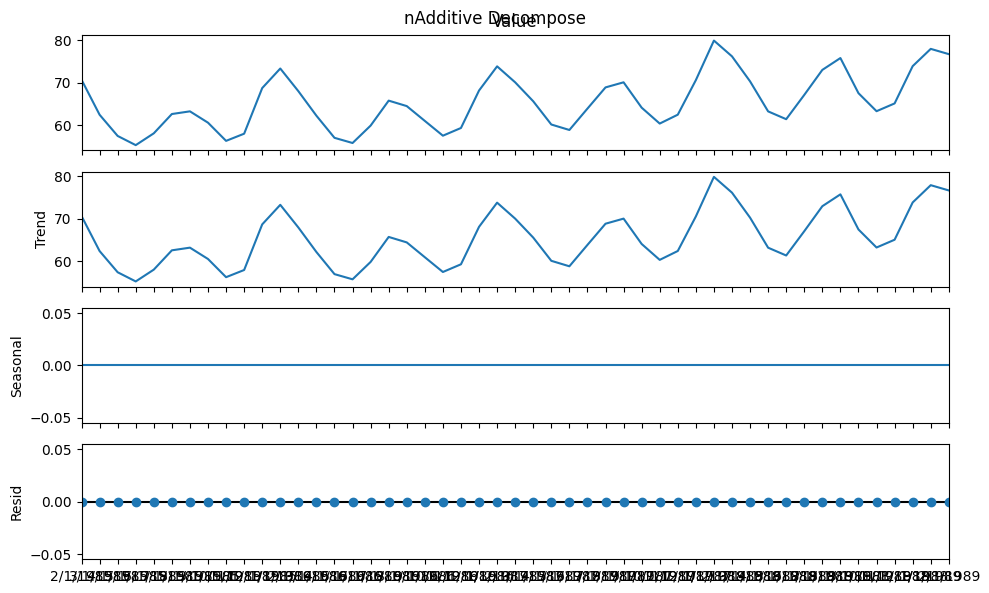

In [15]:
add_result.plot().suptitle('nAdditive Decompose', fontsize=12)
plt.show()

In [16]:
new_df_add = pd.concat([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed], axis=1)
new_df_add.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_add.head()

,seasoanilty,trend,residual,actual_values
DATE,,,,
2/1/1985,0.0,70.6720,0.0,70.6720
3/1/1985,0.0,62.4502,0.0,62.4502
4/1/1985,0.0,57.4714,0.0,57.4714
5/1/1985,0.0,55.3151,0.0,55.3151
6/1/1985,0.0,58.0904,0.0,58.0904


In [17]:
# Step 3: ADfuller test for stationary
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(data.Value.values, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 1.155882602283873
p-value: 0.995666439644432
Critial Values:
   1%, -3.6155091011809297
Critial Values:
   5%, -2.941262357486514
Critial Values:
   10%, -2.6091995013850418


## XGBoost Regressor for Forecasting 

In [18]:
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt

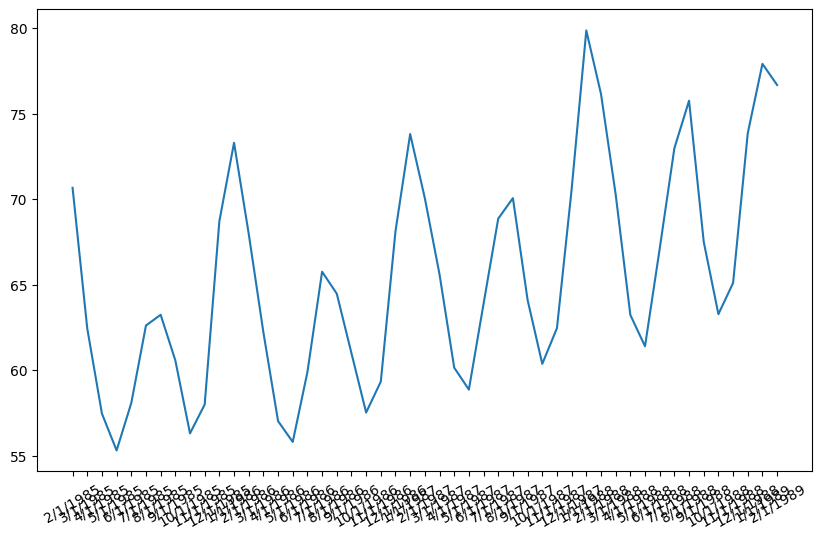

<Figure size 2000x1000 with 0 Axes>

In [20]:
# Load data:
df = pd.read_csv("data/Electric_Production.csv", header=0, index_col=0)
df.rename(columns={'IPG2211A2N': 'Value'}, inplace=True)

plt.plot(df[1:50]["Value"])
plt.xticks(rotation=30)
plt.figure(figsize = (20, 10))
plt.show()

In [21]:
original_data = df.copy()

In [23]:
# Creating lag features for time-series data

def create_lag_features(data, lag_steps=1):

    for i in range(1, lag_steps + 1):

        data[f'lag_{i}'] = data['Value'].shift(i)

    return data

# Applying lag feature creation to the dataset

lagged_data = create_lag_features(original_data, lag_steps=3)

In [24]:
# Creating rolling mean for time-series data

def create_rolling_mean(data, window_size=3):

    data['rolling_mean'] = data['Value'].rolling(window=window_size).mean()

    return data

# Applying rolling mean to the dataset

rolled_data = create_rolling_mean(original_data, window_size=5)

In [25]:
# Applying Fourier transformation for capturing seasonality

from scipy.fft import fft

def apply_fourier_transform(data):

    values = data['Value'].values

    fourier_transform = fft(values)

    data['fourier_transform'] = np.abs(fourier_transform)

    return data

# Applying Fourier transformation to the dataset

fourier_data = apply_fourier_transform(original_data)

In [26]:
# Splitting time-series data into testing and testing sets

train_size = int(len(data) * 0.8)

train_data, test_data = data[:train_size], data[train_size:]

In [28]:
X_train = train_data.drop('Value', axis=1)
y_train = train_data['Value']

X_test = test_data.drop('Value', axis=1)
y_test = test_data['Value']

In [29]:
# # Implementing regularization in XGBoost

# xgb_model = XGBRegressor(learning_rate=0.1, max_depth=5, subsample=0.9, reg_alpha=0.1, reg_lambda=0.1)

In [32]:
# Hyperparameter tuning using grid search

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

xgb_model = XGBRegressor(**best_params)

# Implementing regularization in XGBoost

# xgb_model = XGBRegressor(learning_rate=0.1, max_depth=5, subsample=0.9, reg_alpha=0.1, reg_lambda=0.1)

ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/sklearn.py", line 1081, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/data.py", line 1402, in next
    input_data(**self.kwargs)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/core.py", line 625, in input_data
    dispatch_proxy_set_data(self.proxy, new, cat_codes)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/data.py", line 1461, in dispatch_proxy_set_data
    _check_data_shape(data)
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/data.py", line 57, in _check_data_shape
    if hasattr(data, "shape") and len(data.shape) != 2:
  File "/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/xgboost/data.py", line 593, in shape
    return self.columns[0].shape[0], len(self.columns)
IndexError: list index out of range


In [ ]:
# Evaluating the XGBoost model on the testing set

from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(mae, rmse)

## Advanced Techniques:

In [ ]:
# # Adding seasonal and trend features to the dataset

# data['seasonal_feature'] = data['timestamp'].apply(lambda x: seasonal_pattern(x))

# data['trend_feature'] = data['timestamp'].apply(lambda x: trend_pattern(x))

In [ ]:
# # Differencing technique for handling non-stationary data

# data['stationary_target'] = data['target'].diff()

In [ ]:
# # Including external factors in the dataset

# data = pd.merge(data, external_factors, on='timestamp', how='left')

In [ ]:
# # Selecting evaluation metrics based on business objectives

# evaluation_metrics = ['mae', 'rmse', 'mape']

In [ ]:
# # Displaying feature importance scores

# feature_importance = xgb_model.feature_importances_

In [ ]:
# # Implementing regularization in XGBoost

# xgb_model = XGBRegressor(learning_rate=0.1, max_depth=5, subsample=0.9, reg_alpha=0.1, reg_lambda=0.1)